# ART Sampler

ART stands for A Reconstruction Tool, and the ART Sampler is a probability sampler that uses Gaussian process reconstruction to achieve its goal. Upon completion, the ART Sampler provides an approximated reconstruction of the probability surface given an initial log-posterior probability function. It will also contain MCMC chains (produced using `emcee`).

This notebook will demonstrate how to use the ART Sampler on an extremely simple example problem for which we know the answer exactly.

In [1]:
import numpy as np
import emcee
import pyDOE2
import matplotlib.pyplot as plt
import ARTsampler
%matplotlib inline

In [2]:
#Plot configurations
plt.rc("text", usetex=True)
plt.rc("font", size=24, family="serif")

## Step 0: define a true distribution
We will start with a simple example - a 2D Gaussian distribution.

Our target distribution needs a log-likelihood. We will assume a flat prior so that the posterior is just the likelihood. In this really silly example, the likelihood knows the true mean and covariance, but in a real analysis there would be some kind of model involved.

In a real analysis, the only thing required would be to assemble the `args` dictionary and define the likelihood.

Text(0, 0.5, '$y$')

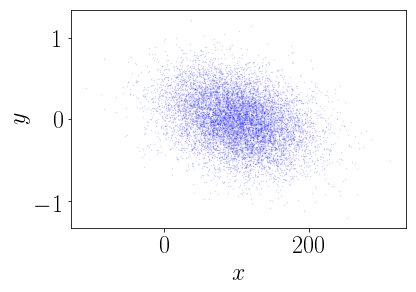

In [3]:
#True mean and covariance
true_means = np.array([100.0, 0.0])
stddevs = np.array([50.0, 0.1]) #standard deviations
rho = -0.99 #correlation
true_cov = np.array([[stddevs[0]**2, rho*stddevs[0]*stddevs[1]],
                    [rho*stddevs[0]*stddevs[1], stddevs[1]]])

#Plot a bunch of samples
true_samples = np.random.multivariate_normal(mean=true_means, cov=true_cov, size=10000).T
plt.scatter(true_samples[0], true_samples[1], marker='.', c='b', alpha=0.2, s=0.5)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

In [4]:
#Assemble an arguments dictionary for the log-likelihood
loglike_args = {"true_mean": true_means, "true_covariance": true_cov}

def true_log_likelihood(params, args):
    #Params is a 2D array containing the two parameters (labeled x and y in figures)
    mu = args["true_mean"]
    C = args["true_covariance"]
    D = mu - params
    return -0.5 * np.dot(D, np.linalg.solve(C, D))

## Step 1: guess a mean and covariance and make an ARTsampler object
The first step for the reconstruction sampler is to guess a mean and covariance. From here we can create the sampler object.

In [5]:
#Our guess for the mean and covariance
guess_mean = np.array([20.0, 0.5]) #Note: parameter y is 5sigma away from the true mean
guess_cov = np.array([[30.**2, 0],[0, 0.08**2]])

In [6]:
sampler = ARTsampler.ARTsampler(guess_mean, guess_cov, true_log_likelihood, loglike_args, quiet=False, 
                                Ntraining_points=100, Nburn = 200, Nsteps=2000)

Let's now plot the current training points in comparison to the truth samples.

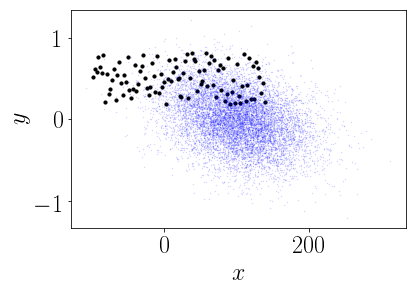

In [7]:
training_points = sampler.get_training_points()
plt.scatter(training_points[:,0], training_points[:,1], c='k', s=10, zorder=1)

plt.scatter(true_samples[0], true_samples[1], marker='.', c='b', alpha=0.2, s=0.5)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.savefig("initial_points.png", dpi=300, bbox_inches="tight")

# Step 2: iterate until we hit the maximum number of iterations (2)
The default maximum number of iterations is two. Let's iterate until we are done.

In [8]:
while sampler.single_iteration():
    continue

Performing iteration 0
Computing log-probability of training points.
      fun: 462.34303307022424
 hess_inv: array([[0.00043666]])
      jac: array([-2.82281494])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 63
      nit: 3
     njev: 52
   status: 2
  success: False
        x: array([3.4743531])
Running first burn-in
Running second burn-in
Running production...
Performing iteration 1
Computing log-probability of training points.
      fun: 4648.409059231615
 hess_inv: array([[1.28050104e-08]])
      jac: array([-0.11642456])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 95
      nit: 6
     njev: 83
   status: 2
  success: False
        x: array([2.97344938])
Running first burn-in
Running second burn-in
Running production...
Performing iteration 2
Computing log-probability of training points.
      fun: 8321.82895118891
 hess_inv: array([[5.84684094e-06]])
      jac: array([3.1394043])
  message: 'Desire

# Step 3: analyze everything
We can do things like make corner plots now.

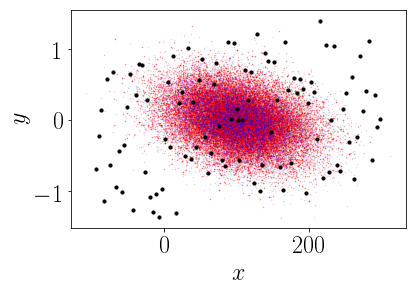

In [9]:
training_points = sampler.get_training_points()
plt.scatter(training_points[:,0], training_points[:,1], c='k', s=10, zorder=1)

samples = sampler.get_samples().T
plt.scatter(samples[0], samples[1], marker='.', c='r', alpha=0.2, s=0.5, zorder=0)

plt.scatter(true_samples[0], true_samples[1], marker='.', c='b', alpha=0.2, s=0.5, zorder=0)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.savefig("truth_vs_artsamples_and_training_points.png", dpi=300, bbox_inches="tight")

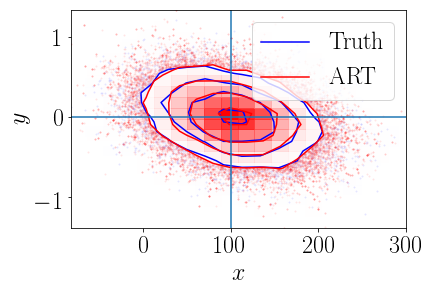

In [10]:
import corner
corner.hist2d(true_samples[0], true_samples[1], color='b', plot_datapoints=1)
corner.hist2d(samples[0], samples[1], color='r', plot_datapoints=1)
plt.plot([], [], color='b',  label="Truth")
plt.plot([], [], color='r',  label="ART")
plt.axvline(true_means[0])
plt.axhline(true_means[1])
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.savefig("truth_vs_art.png", dpi=300, bbox_inches="tight")